In [1]:
import sys 
sys.path.append("../")

from wave_circuit import * 
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator

In [2]:
n = 10
N = 2 ** n
### Verify Swap Circuit ###
np.linalg.norm(Operator(swap_circ(n).reverse_bits()).data - swap_matrix(n))

np.float64(0.0)

In [3]:
QFT_op = Operator(SQFT_circuit(n, swap=True).reverse_bits()).data
print(np.linalg.norm(QFT_op - SQFT_matrix(N)))
print(np.linalg.norm(QFT_op - np.kron(X, np.eye(N//2)) @ swap_matrix(n) @ Operator(SQFT_circuit(n).reverse_bits()).data))

9.38736167109577e-11
0.0


In [4]:
t = 0.4
diag = np.kron([1,-1], N * linear_spectrum_P(N))
abs(np.trace(Operator(linear_evo_cir(n,t).reverse_bits()).data @ np.diag(np.exp(-1j * t * diag)).conjugate().T))

np.float64(2048.0)

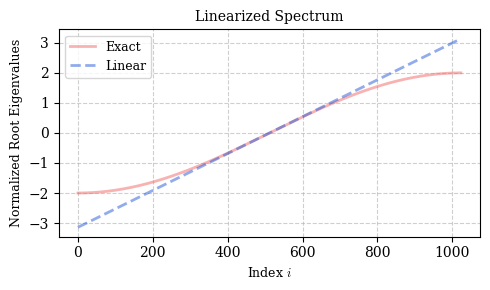

In [5]:
plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif"
})

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(list(range(N)), np.sqrt(-spectrum_P(N)) * np.sign(np.linspace(0, N-1, N) - N//2), label=r"Exact", 
         color=(0.95, 0.40, 0.40), linewidth=2, alpha = 0.5)

plt.plot(list(range(N)), linear_spectrum_P(N), label=r"Linear", 
         color=(0.15, 0.35, 0.85), linestyle="--", linewidth=2, alpha = 0.5)

# Aesthetics
plt.title("Linearized Spectrum", fontsize=10)
plt.xlabel("Index $i$", fontsize=9)
plt.ylabel("Normalized Root Eigenvalues", fontsize=9)
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("../Finalized Figures/Spectra.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [6]:
n = 10
N = 2**n
t = 0.1
qc = simulation_circuit(n, swap = True).assign_parameters([t])
O1 = Operator(qc.reverse_bits()).data

In [7]:
qc = simulation_circuit(n, swap = False).assign_parameters([t])
O2 = Operator(qc.reverse_bits()).data

In [8]:
(np.trace(O1 @ O2.conjugate().T))

np.complex128(2047.9999999999927+0j)

In [9]:
diag = np.kron([1,-1], N * linear_spectrum_P(N))
evo = np.kron(H, SQFT_matrix(N)) @ np.diag(np.exp(-1j * t * diag)) @ np.kron(H, SQFT_matrix(N).conjugate().T)
abs(np.trace(evo @ O1.conjugate().T))

np.float64(2047.999999999996)

In [10]:
from qiskit.quantum_info import Statevector
sigma = 0.1 
mu = 0.5


f = lambda x: 2/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (1 - ((x-mu)/sigma)**2 ) * np.exp(- (x-mu)**2/(2*sigma**2))
df = lambda x: -4/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (x-mu)/(sigma**2) * np.exp(- (x-mu)**2/(2*sigma**2)) - (x-mu)/(sigma**2) * f(x)


init_state = f(np.linspace(0,1-1/N,N) + 1/(2*N))
init_state = np.concatenate([init_state, np.zeros(N)])
K = np.linalg.norm(init_state)

init_state = init_state/K

f_extend = lambda x : f(x - np.floor(x))/K
df_extend = lambda x : df(x - np.floor(x))/K

In [11]:
from scipy.linalg import fractional_matrix_power, expm
n = 10
N = 2**n


f_evo = lambda x,t :  1/2 * (f_extend(x - t) + f_extend(x + t))

dxf_evo = lambda x,t :1/2 * (df_extend(x - t) + df_extend(x + t))
dtf_evo = lambda x,t : 1/2 * (-df_extend(x - t) + df_extend(x + t))

In [12]:
def linear_evo_op(t):
    qc = simulation_circuit(n, swap = False).assign_parameters([t])
    op = Operator(qc.reverse_bits()).data
    
    return op

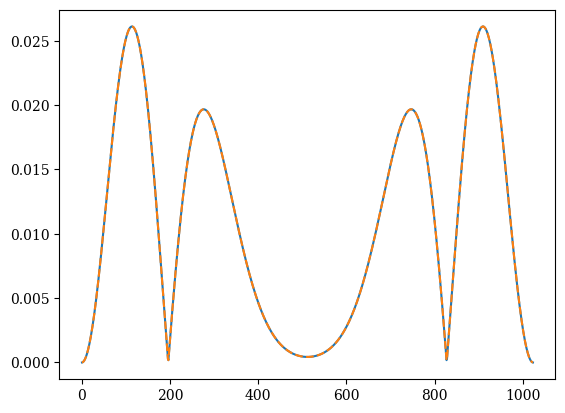

In [13]:
t = 0.4
plt.plot(abs((linear_evo_op(t) @ init_state)[:N]))

plt.plot([abs(f_evo(_,t)) for _ in np.linspace(1/(2*N), 1- 1/(2*N), N)],"--")

In [14]:
def n_int(fun):
    return 1/N * np.sum([fun(_) for _ in np.linspace(1/(2*N), 1 - 1/(2*N), N)])

In [15]:
def T(t):
    return n_int(lambda x : dtf_evo(x,t)**2)

def U(t):
    return n_int(lambda x : dxf_evo(x,t)**2)

def circ_E(t):
    state = (linear_evo_op(t) @ init_state)
    T_state  = state[N:]
    U_state = state[:N]
    return (-U_state.conjugate().T @ (N**2 * L_P(N)) @ U_state / N).real, (-T_state.conjugate().T @ (N ** 2 * L_P(N)) @ T_state / N).real


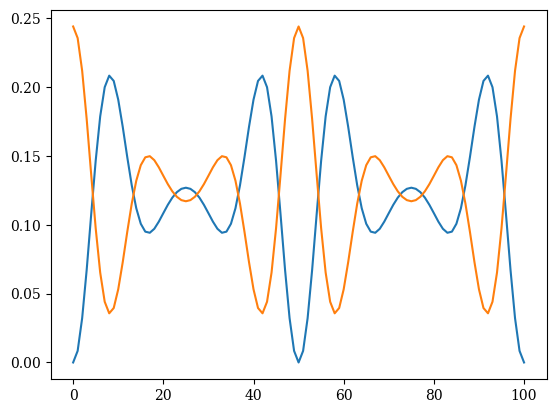

In [16]:
plt.plot([T(_) for _ in np.linspace(0, 1, 101)])
plt.plot([U(_) for _ in np.linspace(0, 1, 101)])
E_data = [circ_E(_) for _ in np.linspace(0, 1, 101)]

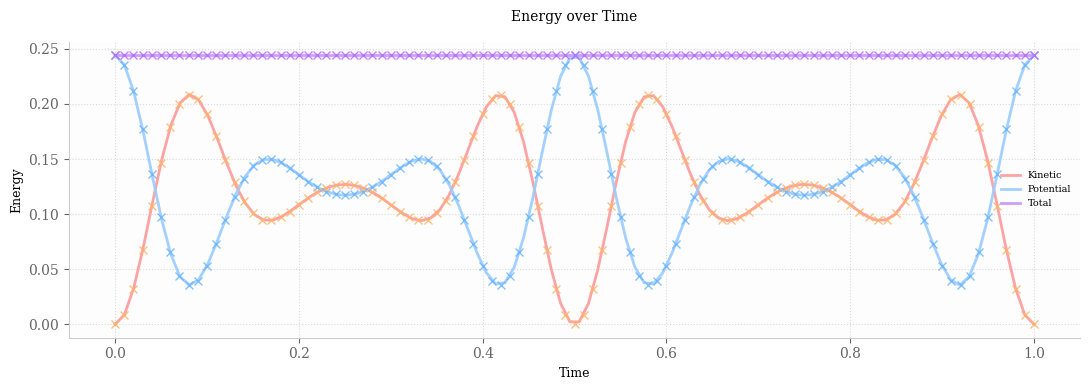

In [19]:
plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif"
})


# Physics-themed pastel colors
colors = {
    'kinetic': '#FF9999',      # Soft red for kinetic energy
    'potential': '#99CCFF',    # Soft blue for potential energy  
    'total': '#CC99FF',        # Soft purple for total energy
    'kinetic_data': '#FFB366', # Soft orange for kinetic data
    'potential_data': '#66B3FF', # Soft cyan for potential data
    'total_data': '#B366FF'    # Soft magenta for total data
}

plt.figure(figsize=(11, 4))

# Your original code with enhanced styling
plt.plot(np.linspace(0, 1, 100), [T(_) for _ in np.linspace(0, 1, 100)], 
         color=colors['kinetic'], linewidth=2, alpha=0.9, 
         label='Kinetic')

plt.plot(np.linspace(0, 1, 100), [U(_) for _ in np.linspace(0, 1, 100)], 
         color=colors['potential'], linewidth=2, alpha=0.9, 
         label='Potential')

plt.plot(np.linspace(0, 1, 101), [E[0] for E in E_data], 'x', 
         color=colors['potential_data'], linewidth=0, alpha=0.8, 
)

plt.plot(np.linspace(0, 1, 101), [E[1] for E in E_data], 'x', 
         color=colors['kinetic_data'], linewidth=0, alpha=0.8, 
        )

plt.plot(np.linspace(0, 1, 100), [T(_) + U(_) for _ in np.linspace(0, 1, 100)], 
         color=colors['total'], linewidth=2, alpha=0.95, 
         label='Total')

plt.plot(np.linspace(0, 1, 101), [E[0]+E[1] for E in E_data], "x", 
         color=colors['total_data'], linewidth=0, alpha=0.8, 
         )

# Enhanced aesthetics
plt.grid(True, alpha=0.3, linestyle=':', color='#888')
plt.xlabel('Time', fontsize=9)
plt.ylabel('Energy', fontsize=9)
plt.title('Energy over Time', fontsize=10, pad=15)

# Better legend - more compact
plt.legend(loc='center right', frameon=False, 
          fontsize=7, framealpha=0.95, ncol=1, columnspacing=1.5)

# Clean styling  
plt.gca().set_facecolor('#fdfdfd')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#ccc')
ax.spines['bottom'].set_color('#ccc')
ax.tick_params(colors='#666')

plt.tight_layout()
plt.savefig("../Finalized Figures/energy.pdf", dpi=300)
plt.show()

In [20]:
t_vals = np.linspace(0, 1, 100)
n_list = range(5, 11)
fid_full = []
for n in n_list:
    def linear_evo_op(t):
        qc = simulation_circuit(n, swap = False).assign_parameters([t])
        op = Operator(qc.reverse_bits()).data
        return op
    
    N = 2**n
    init_state = np.concatenate([f(np.linspace(1/(2*N), 1-1/(2*N), N)), np.zeros(N)])
    K = np.linalg.norm(init_state)
    init_state = init_state/K
    
    fid = []
    for t in t_vals:
        v1 = np.array([f_evo(_, t) for _ in np.linspace(1/(2*N), 1-1/(2*N), N)])
        v2 = (linear_evo_op(t) @ init_state)[:N]
        fid.append(np.max(abs(abs(v1) - abs(v2))))
    fid_full.append(fid)

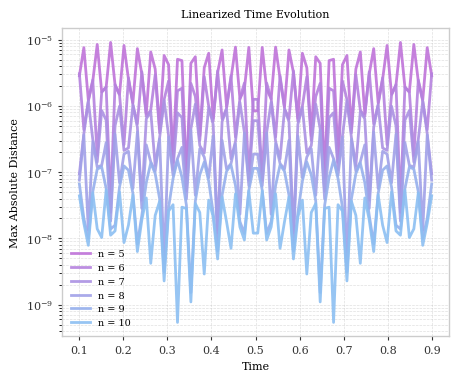

In [21]:

# Define compatible pastel colormap (slightly different from first plot)
pastel_colors_v2 = [
    (0.75, 0.45, 0.85),   # pastel purple
    (0.55, 0.75, 0.95),   # pastel sky blue
]
import matplotlib.colors as plt_colors
fig, ax = plt.subplots(figsize=(5, 4))

# Create colormap for the 4 lines (m = 4, 5, 6, 7)
cmap = plt_colors.LinearSegmentedColormap.from_list("compatible_pastel", pastel_colors_v2, N=6)
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

plt.xlabel("Time", fontsize=8, labelpad=4)
plt.ylabel("Max Absolute Distance", fontsize=8, labelpad=4)
plt.title("Linearized Time Evolution", fontsize=8, pad=8)


plt.yscale('log')

for idx, (n, y_values) in enumerate(zip(range(5,11), fid_full)):
    x_values = np.linspace(0,1,100)
    
    plt.plot(x_values[10:-10], y_values[10:-10], 
             color=colors[idx], 
             linewidth=2, 
             alpha=0.9,
             label=f'n = {n}',
             markersize=4,
             markerfacecolor=colors[idx],
             markeredgecolor='white',
             markeredgewidth=1)

# Set spine colors to match
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)


plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

plt.legend(loc="best", fontsize=7, frameon=False)

plt.savefig("../Finalized Figures/Linear Error.pdf", bbox_inches='tight', dpi=300)
plt.show()